In [9]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [10]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
#import tensorflow.contrib.layers as tf_cl
from PIL import Image
import concurrent.futures
import glob
from cv2 import imwrite
import cv2
import random
from sewar.full_ref import mse, rmse, ssim, uqi, psnr

In [11]:
def l1loss(x, y):

    return tf.reduce_mean(tf.abs(x - y))

In [12]:
def l2loss(x, y):
  
    return tf.reduce_mean(tf.math.square(x-y))

In [13]:
 def DSSIMloss(real,gen,max_val = 1):
   
    ssim = tf.image.ssim(real, gen,max_val = 1)
    dssim = tf.reduce_mean(((1.0 - ssim) / 2))
    
    return dssim
    

In [14]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.compat.v1.variable_scope(name):
        return tf.maximum(x, leak * x)

In [15]:
def instance_norm(x, epsilon=1e-5):
    with tf.compat.v1.variable_scope('instance_norm',reuse=tf.compat.v1.AUTO_REUSE):
        mean, var = tf.nn.moments(x, [1, 2], keepdims=True)
        scale = tf.compat.v1.get_variable(
            name='scale', 
            shape=[x.get_shape()[-1]],
            initializer=tf.compat.v1.truncated_normal_initializer(mean=1.0, stddev=0.02))
        offset = tf.compat.v1.get_variable(
            name='offset',
            shape=[x.get_shape()[-1]],
            initializer=tf.constant_initializer(0.0))
        out = scale * tf.math.divide(x - mean, tf.math.sqrt(var + epsilon)) + offset
        return out

In [16]:
def conv2d(inputs,
           activation_fn=lrelu,
           normalizer_fn=instance_norm,
           scope='conv2d',
           **kwargs):
    with tf.compat.v1.variable_scope(scope or 'conv2d'):
        h = tf.keras.layers.Conv2D(
            activation=None,
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            bias_initializer=None,
            **kwargs)(inputs)
        if normalizer_fn:
            h = normalizer_fn(h)
        if activation_fn:
            h = activation_fn(h)
        return h

In [17]:
def upconv(inputs,
           activation_fn=lrelu,
           normalizer_fn=instance_norm,
           scope='upconv',
           **kwargs):
    with tf.compat.v1.variable_scope(scope or 'upconv'):
        h = tf.keras.layers.Conv2DTranspose(
            activation=None,
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            bias_initializer=None,
            **kwargs)(inputs)
        if normalizer_fn:
            h = normalizer_fn(h)
        if activation_fn:
            h = activation_fn(h)
        return h

In [18]:
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.compat.v1.variable_scope(scope or "Linear"):
        matrix = tf.compat.v1.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.compat.v1.get_variable("bias", [output_size],
        initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.linalg.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.linalg.matmul(input_, matrix) + bias

In [19]:
def generator(image,scope = None):
  
  with tf.compat.v1.variable_scope(scope or 'generator', reuse = tf.compat.v1.AUTO_REUSE):
    
    def dil_conv(l,in_channel):
      
      l_3X3 = tfl.Conv2D(in_channel, 3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_3X3r2 = tfl.Conv2D(in_channel, 5, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                           activation=tf.nn.relu)(l)
      l_3X3r4 = tfl.Conv2D(in_channel, 9, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                           activation=tf.nn.relu)(l)
      l_3X3r6 = tfl.Conv2D(in_channel, 13, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1,1), 
                           activation=tf.nn.relu)(l)
      
    
      concat = tf.concat([l_3X3,l_3X3r2,l_3X3r4,l_3X3r6],3)
      
      
      l_3X1 = tfl.Conv2D(in_channel, (3,1), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_1X3 = tfl.Conv2D(in_channel, (1,3), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_hv3 = tf.math.add(l_3X1,l_1X3)
      l_hv3 = tf.math.divide(l_hv3,2)
      
      l_5X1 = tfl.Conv2D(in_channel, (5,1), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_1X5 = tfl.Conv2D(in_channel, (1,5), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_hv5 = tf.math.add(l_5X1,l_1X5)
      l_hv5 = tf.math.divide(l_hv5,2)
      
      l_9X1 = tfl.Conv2D(in_channel, (9,1), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_1X9 = tfl.Conv2D(in_channel, (1,9), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(l)
      l_hv9 = tf.math.add(l_9X1,l_1X9)
      l_hv9 = tf.math.divide(l_hv9,2)
      
      l_13X1 = tfl.Conv2D(in_channel, (13,1), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)(l)
      l_1X13 = tfl.Conv2D(in_channel, (1,13), strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)(l)
      l_hv13 = tf.math.add(l_13X1,l_1X13)
      l_hv13 = tf.math.divide(l_hv13,2)
      
      
      concat1 = tf.concat([l_hv3,l_hv5,l_hv9,l_hv13],3)
      
      agg = tf.math.add(concat, concat1)
      
      agg = concat
      l_1X1 = tfl.Conv2D(in_channel,1, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                         activation=tf.nn.relu)(agg)
      
      return l_1X1
    

    
    
    def channel_attention(l1,l2):
      
      
      depth = l1.get_shape()[-1]
      
      op_ch1 = l1
      ch2 = tf.math.reduce_mean(l2, axis=[1,2],keepdims=True)
      ch2 = tfl.Conv2D(depth, 1, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), activation=None)(ch2)
      ch2 = tf.nn.relu(ch2)
      ch2 = tfl.Conv2D(depth, 1, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), activation=None)(ch2)
      ch2 = tf.nn.sigmoid(ch2)
      
      op_ch2 = tf.multiply(ch2,l1)
      
      ch_op = tf.add(op_ch1,op_ch1)
      
      return ch_op
    
    def spatial_attention(l1,l2):
      
      op_sp1 = l1
      
      sp2 = tf.math.reduce_mean(l2, axis=[3],keepdims=True)
      sp2 = tfl.Conv2D(1, 1, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), activation=None)(sp2)
      sp2 = tf.nn.relu(sp2)
      sp2 = tfl.Conv2D(1, 1, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), activation=None)(sp2)
      sp2 = tf.nn.sigmoid(sp2)
      
      op_sp2 = tf.multiply(sp2,l1)
      
      sp_op = tf.add(op_sp1,op_sp1)
      
      return sp_op
      
      
    with tf.compat.v1.variable_scope('block_down1',reuse = tf.compat.v1.AUTO_REUSE) as scope:
      l1_res = tfl.Conv2D(8,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)(image)
      l1 = dil_conv(l1_res,8)
      added_1=tf.math.add(l1_res,l1)
      l_down1 = tf.nn.space_to_depth(added_1,block_size = 2)

    with tf.compat.v1.variable_scope('block_down2',reuse = tf.compat.v1.AUTO_REUSE) as scope:
      l2_res = tfl.Conv2D(32,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)
    (l_down1)
      l2 = dil_conv(l2_res,32)
      added_2 =tf.math.add(l2_res,l2)
      l_down2 = tf.nn.space_to_depth(added_2,block_size = 2)


    with tf.compat.v1.variable_scope('block_down3',reuse = tf.compat.v1.AUTO_REUSE) as scope:
      l3_res = tfl.Conv2D(128,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)(l_down2)
      l3 = dil_conv(l3_res,128)
      added_3 =tf.math.add(l3_res,l3)
      l_down3 = tf.nn.space_to_depth(added_3,block_size = 2)

    with tf.compat.v1.variable_scope('block_down4',reuse = tf.compat.v1.AUTO_REUSE) as scope:
      l4_res = tfl.Conv2D(512,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                          activation=tf.nn.relu)(l_down3)
      l4 = dil_conv(l4_res,512)
      added_4 =tf.math.add(l4_res,l4)
      l_down4 = tf.nn.space_to_depth(added_4,block_size = 2)

    h  = l_down4


    with tf.compat.v1.variable_scope('block_up1',reuse=tf.compat.v1.AUTO_REUSE) as scope:
      l_up1 = tf.nn.depth_to_space(h,block_size = 2)
      at = tf.nn.space_to_depth(added_1,8)
      ch_at1 = channel_attention(added_4,at)
      sp_at1 = spatial_attention(added_4,at)
      l_con1 = tf.concat([l_up1,ch_at1,sp_at1],3)
      
      ch1 = tf.nn.depth_to_space(l_con1,block_size = 8)
      ch1 = tfl.Conv2D(1,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                       activation=tf.nn.relu)(ch1)

    with tf.compat.v1.variable_scope('block_up2',reuse=tf.compat.v1.AUTO_REUSE) as scope:
      l_up2 = tf.nn.depth_to_space(l_con1,block_size = 2)
      at = tf.nn.space_to_depth(added_2,2)
      ch_at2 = channel_attention(added_3,at)
      sp_at2 = spatial_attention(added_3,at)
      l_con2 = tf.concat([l_up2,ch_at2,sp_at2],3)
      
      ch2 = tf.nn.depth_to_space(l_con2,block_size = 4)
      ch2 = tfl.Conv2D(1,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                       activation=tf.nn.relu)(ch2)

    with tf.compat.v1.variable_scope('block_up3',reuse=tf.compat.v1.AUTO_REUSE) as scope:
      l_up3 = tf.nn.depth_to_space(l_con2,block_size = 2)
      at = tf.nn.depth_to_space(added_3,2)
      ch_at3 = channel_attention(added_2,at)
      sp_at3 = spatial_attention(added_2,at)
      l_con3 = tf.concat([l_up3,ch_at3,sp_at3],3)
      
      ch3 = tf.nn.depth_to_space(l_con3,block_size = 2)
      ch3 = tfl.Conv2D(1,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                       activation=tf.nn.relu)(ch3)


    with tf.compat.v1.variable_scope('block_up4',reuse=tf.compat.v1.AUTO_REUSE) as scope:
      l_up4 = tf.nn.depth_to_space(l_con3,block_size = 2)
      at = tf.nn.depth_to_space(added_4,8)
      ch_at4 = channel_attention(added_1,at)
      sp_at4 = spatial_attention(added_1,at)
      l_con4 = tf.concat([l_up4,ch_at4,sp_at4],3)
      
      ch4 = tfl.Conv2D(1,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                       activation=tf.nn.relu)(l_con4)
      

    l_out3 = tfl.Conv2D(16,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                        activation=tf.nn.relu)(l_con4)
    l_out2 = tfl.Conv2D(8,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                        activation=tf.nn.relu)(l_out3)
    l_out1 = tfl.Conv2D(1,3, strides=(1, 1), padding='same', data_format=None,dilation_rate=(1, 1), 
                        activation=tf.nn.relu)(l_out2)

    return l_out1,ch1,ch2,ch3,ch4 

In [33]:
def discriminator(x, n_filters=64, k_size=4, scope=None, reuse=tf.compat.v1.AUTO_REUSE):
    with tf.compat.v1.variable_scope(scope or 'discriminator', reuse=reuse):
        h = conv2d(
            inputs=x,
            filters=n_filters,
            kernel_size=k_size,
            strides=1,
            scope='1')
        i1 = h.shape
        ken = tf.reshape(h, [192, -1])
        code = (linear(ken, 32, scope='d_fc6'))
        h = conv2d(
            inputs=h,
            filters=n_filters * 2,
            kernel_size=k_size,
            strides=1,
            scope='2')
        i2 = h.shape
        h = conv2d(
            inputs=h,
            filters=n_filters * 4,
            kernel_size=k_size,
            strides=1,
            scope='3')
        h = upconv(
            inputs=h,
            filters=n_filters * 2,
            kernel_size=k_size,
            strides=1,
            scope='2')
        h = upconv(
            inputs=h,
            filters=n_filters,
            kernel_size=k_size,
            strides=1,
            scope='1')
        #i5 = h.shape
        h = upconv(
            inputs=h,
            filters=1,
            kernel_size=k_size,
            strides=1,
            activation_fn=tf.keras.activations.linear,
            scope='5')
        i6 = h.shape

        return h,i1,code

In [34]:
tf.compat.v1.disable_eager_execution()
def inhomonet(img_size=192):

    X_real = tf.compat.v1.placeholder(
        name='X', shape=[1, img_size, img_size, 1], dtype=tf.float32)
    Y_real = tf.compat.v1.placeholder(
        name='Y', shape=[1, img_size, img_size, 1], dtype=tf.float32)
    Y_fake_sample = tf.compat.v1.placeholder(
        name='Y_fake_sample',
        shape=[None, img_size, img_size, 1],
        dtype=tf.float32)
    HC = tf.compat.v1.placeholder(
        name='HC', shape=(), dtype=tf.float32)
    DP = tf.compat.v1.placeholder(
        name='3DP', shape=(), dtype=tf.float32)
    
    
    Y_fake,ch1,ch2,ch3,ch4 = generator(X_real, scope='G_xy')
    
    #Y_fake1 = tf.reshape(Y_fake, [1,16,16,1])


    
    D_Y_real,i1,D_Y_realcode = discriminator(Y_real, scope='D_Y')
    D_Y_fake,j1,D_Y_fakecode = discriminator(Y_fake, scope='D_Y' ,reuse=True)
    D_Y_fake_sample,k1,D_Y_fake_samplecode = discriminator(Y_fake_sample, scope='D_Y',reuse=True )
    
    print(i1)
    print(Y_fake.shape)
    

    
    # Create losses for generators
    l1 = 10
    l2 = 100

    #loss_G_xy = l2loss(D_Y_fake, 1.0)
    loss_G_xy = l2loss(D_Y_fake, Y_fake)
    ssimxy = DSSIMloss(Y_fake, Y_real,max_val = 1)
    recon_fy = l1loss(Y_fake,Y_real)
    r1 = l1loss(ch1,Y_real)
    r2 = l1loss(ch2,Y_real)
    r3 = l1loss(ch3,Y_real)
    r4 = l1loss(ch4,Y_real)
    
    #Pullaway term regularizer
    #embeddings = tf.reshape(Y_fake,[-1])
    norm = tf.sqrt(tf.reduce_sum(tf.square(D_Y_fakecode), 1, keepdims=True))
    normalized_embeddings = D_Y_fakecode/norm
    similarity = tf.matmul(normalized_embeddings, normalized_embeddings, transpose_b=True)
    batch_size = tf.cast(tf.shape(D_Y_fakecode)[0], tf.float32)
    pt_loss = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    pt_lossweight = 0.1
    loss_pt = pt_lossweight*pt_loss
    
    t_r = r1+r2+r3+r4 +recon_fy
    #loss_mix = MSSSIMl1loss(Y_fake,Y_real)
    #ffl = FFL(loss_weight=1.0, alpha=1.0)
    #loss_ffl = ffloss(Y_real,Y_fake)
    MSSSIM=tf.image.ssim_multiscale(Y_fake,Y_real,max_val=1)
    #loss_msssim = tf.reduce_mean(1.0 - MSSSIM)
    
    loss_G = loss_G_xy + (l1*t_r) + HC + loss_pt + DP 
        
    #Performence Metrics Added
    SSIM = tf.image.ssim(Y_fake,Y_real,max_val = 1)
    PSNR = tf.image.psnr(Y_fake,Y_real,max_val=1)
    #MSE = tf.keras.metrics.mean_squared_error(Y_fake,Y_real)
    #RMSE = tf.math.sqrt(MSE)
    #accuracy = tf.reduce_mean(tf.cast(Y_fake,tf.int32))
 

    #Create losses for discriminators
    loss_D_Y = l2loss(D_Y_real, Y_real) + tf.math.maximum(l2loss(D_Y_fake_sample, Y_fake_sample),0) #altered
    #loss_D_Y = l2loss(D_Y_real, 0) + l2loss(D_Y_fake_sample, 1.0) 


    # Summaries for monitoring training
    tf.compat.v1.summary.image("Y_fake", Y_fake, max_outputs=1)
    tf.compat.v1.summary.image("Y_real", Y_real, max_outputs=1)
    tf.compat.v1.summary.image("X_real", X_real, max_outputs=1)
    tf.compat.v1.summary.image("ch1", ch1, max_outputs=1)
    tf.compat.v1.summary.image("ch2", ch2, max_outputs=1)
    tf.compat.v1.summary.image("ch3", ch3, max_outputs=1)
    tf.compat.v1.summary.image("ch4", ch4, max_outputs=1)

    tf.compat.v1.summary.scalar("Recon_loss", t_r)
    tf.compat.v1.summary.scalar("G_loss", loss_G_xy)
    tf.compat.v1.summary.scalar("His_corr_loss", HC)
    tf.compat.v1.summary.scalar("3DP_loss", DP)
    tf.compat.v1.summary.scalar("Total_loss",loss_G)
    tf.compat.v1.summary.scalar("D_loss",loss_D_Y)
    #tf.compat.v1.summary.scalar("FFL_loss", loss_ffl)
    tf.compat.v1.summary.scalar("SSIM",tf.reduce_mean(SSIM))
    tf.compat.v1.summary.scalar("PSNR",tf.reduce_mean(PSNR))
    #tf.compat.v1.summary.scalar("MSE",MSE)
    #tf.compat.v1.summary.scalar("RMSE",RMSE)
    tf.compat.v1.summary.scalar("MSSSIM",tf.reduce_mean(MSSSIM))
    #tf.compat.v1.summary.scalar("Accuracy",accuracy)


    summaries = tf.compat.v1.summary.merge_all()
    
    training_vars = tf.compat.v1.trainable_variables()

    D_Y_vars = [v for v in training_vars if v.name.startswith('D_Y')]
    G_xy_vars = [v for v in training_vars if v.name.startswith('G_xy')]
    #mix_vars = [v for v in training_vars if v.name.startswith('mix')]

    return locals()

In [35]:
net = inhomonet(img_size=192)

(1, 189, 189, 64)
(1, 192, 192, 1)


In [26]:
list(net.items())

[('img_size', 192),
 ('X_real', <tf.Tensor 'X_1:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('Y_real', <tf.Tensor 'Y_1:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('Y_fake_sample',
  <tf.Tensor 'Y_fake_sample_1:0' shape=(None, 192, 192, 1) dtype=float32>),
 ('HC', <tf.Tensor 'HC_1:0' shape=() dtype=float32>),
 ('DP', <tf.Tensor '3DP_1:0' shape=() dtype=float32>),
 ('Y_fake',
  <tf.Tensor 'G_xy_1/conv2d_169/Relu:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('ch1',
  <tf.Tensor 'G_xy_1/block_up1/conv2d_151/Relu:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('ch2',
  <tf.Tensor 'G_xy_1/block_up2/conv2d_156/Relu:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('ch3',
  <tf.Tensor 'G_xy_1/block_up3/conv2d_161/Relu:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('ch4',
  <tf.Tensor 'G_xy_1/block_up4/conv2d_166/Relu:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('D_Y_real',
  <tf.Tensor 'D_Y_3/5/instance_norm/add_1:0' shape=(1, 192, 192, 1) dtype=float32>),
 ('i1', TensorShape([1, 189, 189, 64])),
 ('D_Y

In [27]:
folder1 = r'/Users/Pooja/Documents/IntensityInhomogeneityImages'
folder2 = r'/Users/Pooja/Documents/GroundTruth2'

In [28]:
from PIL import Image
def load_images_and_resize(folder1,folder2):
    image_A = []
    image_B = []
    folder1l = os.listdir(folder1)
    folder2l = os.listdir(folder2)

    for filename in folder1l:
        img1 = Image.open(os.path.join(folder1,filename)).convert('L')
        f_name, f_ext = os.path.splitext(filename)
        num = (f_name.split('_'))
        img1 = np.array(img1).astype(np.float32)
        img1=img1/255.0

        img1 = np.reshape(img1, [192,192,1])
        img1 = img1[np.newaxis,...]
        if img1 is not None:
            image_A.append(img1)
    for filename2 in folder2l:
        img2 = Image.open(os.path.join(folder2,filename2)).convert('L')
        img2 = np.array(img2).astype(np.float32)
        img2=img2/255.0

        img2 = np.reshape(img2, [192,192,1])
        img2 = img2[np.newaxis,...]
        if img2 is not None:
            image_B.append(img2)
            
        
    return image_A,image_B

In [29]:
def batch_generator2(imgs1,imgs2):
  n_imgs = min(len(imgs1), len(imgs2))
  ind = random.sample(range(n_imgs),n_imgs)
  for i in ind:
    yield imgs1[i], imgs2[i]

In [30]:
ds_X, ds_Y = load_images_and_resize(folder1,folder2)

In [31]:
def train(ds_X,
          ds_Y,
          ckpt_path='inhomonet',
          learning_rate=0.0002,
          n_epochs=100,
          img_size=256):

    # How many fake generations to keep around
    capacity = 50

    # Storage for fake generations

    fake_Ys = capacity * [
        np.zeros((1, img_size, img_size, 1), dtype=np.float32)
    ]
    idx = 0
    it_i = 0
    loss_curve = []

    # Train
    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
        # Load the network
        net = inhomonet(img_size=img_size)

        # Build optimizers
        D_Y = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(
            net['loss_D_Y'], var_list=net['D_Y_vars'])
        G = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(
            net['loss_G'], var_list=net['G_xy_vars'])
        #mix = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(
            #net['loss_mix'], var_list=net['mix_vars'])

        init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                           tf.compat.v1.local_variables_initializer())
        sess.run(init_op)
        saver = tf.compat.v1.train.Saver()
        writer = tf.compat.v1.summary.FileWriter(ckpt_path)
        
        for epoch_i in range(n_epochs):
            v = 0
            i = 0


            for X, Y in batch_generator2(ds_X, ds_Y):
              
         
                # First generate in both directions
                Y_fake,ch1,ch2,ch3,ch4 = sess.run(
                    [net['Y_fake'],net['ch1'],net['ch2'],net['ch3'],net['ch4']],
                    feed_dict={net['X_real']: X,
                               net['Y_real']: Y})
            
                Y_fake = np.reshape(Y_fake, [1,192,192,1])
                ch1 = np.reshape(ch1,[1,192,192,1])
                ch2 = np.reshape(ch2,[1,192,192,1])
                ch3 = np.reshape(ch3,[1,192,192,1])
                ch4 = np.reshape(ch4,[1,192,192,1])
                ep = epoch_i +1
                
                
                # Now sample from history
                if it_i < capacity:
                    # Not enough samples yet, fill up history buffer
                    fake_Ys[idx] = Y_fake
                    idx = (idx + 1) % capacity
                elif np.random.random() > 0.5:
                    # Swap out a random idx from history
                    rand_idx = np.random.randint(0, capacity)
                    fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
                else:
                    # Use current generation
                    pass

                
                y_fake1 = np.reshape(Y_fake, [192,192])
                y_fake1=y_fake1*255
                y_fake1 = np.clip(y_fake1, a_min = 0,a_max = 255)
                
                y_real1 = np.reshape(Y, [192,192])
                y_real1 = y_real1*255
                
                
                H1f = cv2.calcHist([y_real1],[0],None,[256],[10,256]) 
                H2f = cv2.calcHist([y_fake1],[0],None,[256],[10,256])
                                
                Hsim = cv2.compareHist(H1f,H2f, method = cv2.HISTCMP_CORREL)
                HG_diff = (1-Hsim)
                
                v1 = np.zeros((256,192,192))
                v2 = np.zeros((256,192,192))
                
                for i in range(192):
                  for j in range(192):
                      va1 = int(y_real1[i][j])
                      v1[va1][i][j] = 1
                      va2 = int(y_fake1[i][j])
                      v2[va2][i][j] = 1
                    
                
                err = np.sum(np.abs(v1-v2))
                e1 = (err*100)/(192*192*256)


                 # Optimize G Network
                loss_G = sess.run(
                    [net['loss_G'], G],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['Y_fake_sample']: Y_fake,
                        net['HC'] : HG_diff,
                        net['DP'] : e1
                    })[0]

                # Optimize D_Y
                loss_D_Y = sess.run(
                    [net['loss_D_Y'], D_Y],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['Y_fake_sample']: Y_fake
                    })[0]

                if it_i % 200 == 0:
                    #tf.compat.v1.summary.scalar("loss",loss_G)
                    summary = sess.run(
                        net['summaries'],
                        feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['Y_fake_sample']: Y_fake,
                        net['HC'] : HG_diff,
                        net['DP'] : e1
                        })
                    writer.add_summary(summary, it_i)
                    print(it_i,ep, 'G:', loss_G, 'D_Y:', loss_D_Y, 'Hsim:',Hsim,'HC:', HG_diff, 'DP:', e1)
                    loss_curve.append(loss_G)
                it_i += 1
                
        saver.save(sess,os.path.join(ckpt_path, 'model_final.ckpt'))
        
        
        

In [22]:
%reload_ext tensorboard

In [23]:
#Monitor using Tensorboard
%tensorboard --logdir ./inhomonet

In [32]:
#run to train the network
train(ds_X,ds_Y,ckpt_path='inhomonet',learning_rate=0.0001,n_epochs=100,img_size=192)

(1, 189, 189, 64)
(1, 192, 192, 1)
0 1 G: 10.277663 D_Y: 2.0544698 Hsim: 0.035848601524073716 HC: 0.9641513984759262 DP: 0.5596372816297743


KeyboardInterrupt: 

In [77]:
tensorboard --logdir /Users/Pooja/inhomonet

NameError: name 'tensorboard' is not defined

In [1]:
tensorboard --logdir ./InhomonetData

SyntaxError: invalid syntax (Temp/ipykernel_24696/2664683677.py, line 1)

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from PIL import Image
import concurrent.futures
import glob
from cv2 import imwrite
import cv2
import random
import tensorflow as tf

In [2]:
sess=tf.compat.v1.Session()    
# restore weights
tf.compat.v1.disable_eager_execution()
saver = tf.compat.v1.train.import_meta_graph('./inhomonet/model_final.ckpt.meta')


saver.restore(sess,tf.train.latest_checkpoint('./inhomonet'))
 

graph = tf.compat.v1.get_default_graph()
Y_real = graph.get_tensor_by_name('Y:0')
X_real = graph.get_tensor_by_name('X:0')

Y_fake = graph.get_tensor_by_name('G_xy/conv2d_78/Relu:0')

INFO:tensorflow:Restoring parameters from ./inhomonet\model_final.ckpt


In [3]:
folder1 = r'/Users/Pooja/Documents/GTLena'
folder2 = r'/Users/Pooja/Documents/TestLena'

def load_images_and_resize(folder1,folder2):
    image_A = []
    image_B = []
    folder1l = os.listdir(folder1)
    folder2l = os.listdir(folder2)

    for filename in folder1l:
        img1 = Image.open(os.path.join(folder1,filename)).convert('L')
        f_name, f_ext = os.path.splitext(filename)
        num = (f_name.split('_'))
        img1 = img1.resize((192,192))
        img1 = np.array(img1).astype(np.float32)
        img1=img1/255.0
        img1 = np.reshape(img1, [192,192,1])
        img1 = img1[np.newaxis,...]
        if img1 is not None:
            image_A.append(img1)
    for filename2 in folder2l:
        img2 = Image.open(os.path.join(folder2,filename2)).convert('L')
        img2 = img2.resize((192,192))
        img2 = np.array(img2).astype(np.float32)
        img2=img2/255.0

        img2 = np.reshape(img2, [192,192,1])
        img2 = img2[np.newaxis,...]
        if img2 is not None:
            image_B.append(img2)
            
        
    return image_A,image_B


def batch_generator2(imgs1,imgs2):
  n_imgs = min(len(imgs1), len(imgs2))
  ind = random.sample(range(n_imgs),n_imgs)
  for i in ind:
    yield imgs1[i], imgs2[i]


#load the dataset
ds_Xin, ds_Yout = load_images_and_resize(folder1,folder2)

In [4]:
def Inference(ds_Xin, ds_Yout):
  img_x = []
  img_y = []
  img_pred = []
  i = 0
  for X, Y in batch_generator2(ds_Xin, ds_Yout):

    
    Y_fake_pred = sess.run([Y_fake],feed_dict={X_real: X})


    y_real = np.reshape(X, [192,192])
    img_y.append(y_real)

    x_real = np.reshape(Y, [192,192])
    img_x.append(x_real)

    y_fake = np.reshape(Y_fake_pred, [192,192])
    img_pred.append(y_fake)

    i = i+1
    
  return img_x, img_y, img_pred


#Inference Step
img_IN, img_GT, img_pred = Inference(ds_Xin,ds_Yout)

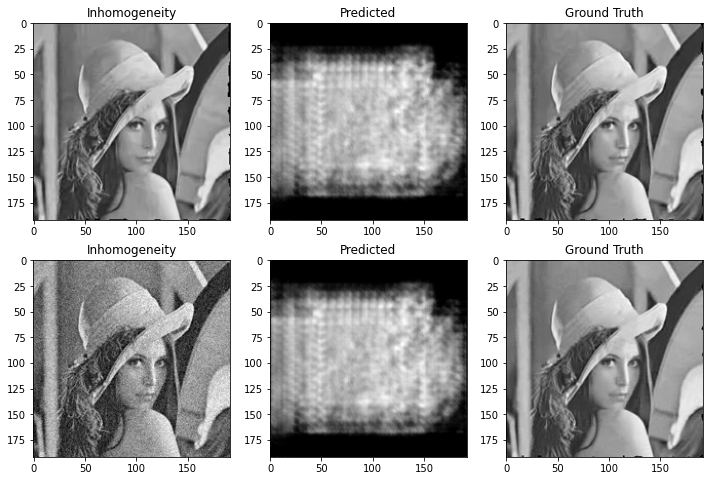

In [6]:
fig = plt.figure(figsize=(12, 8))
r = 2
x = random.sample(range(len(img_IN)),len(img_IN))
fig.add_subplot(r,3,1)
plt.imshow(img_IN[x[0]],cmap='gray')
plt.gca().set_title('Inhomogeneity')
fig.add_subplot(r,3,2)
plt.imshow(img_pred[x[0]],cmap='gray')
plt.gca().set_title('Predicted')
fig.add_subplot(r,3,3)
plt.imshow(img_GT[x[0]],cmap='gray')
plt.gca().set_title('Ground Truth')
fig.add_subplot(r,3,4)
plt.imshow(img_IN[x[1]],cmap='gray')
plt.gca().set_title('Inhomogeneity')
fig.add_subplot(r,3,5)
plt.imshow(img_pred[x[1]],cmap='gray')
plt.gca().set_title('Predicted')
fig.add_subplot(r,3,6)
plt.imshow(img_GT[x[1]],cmap='gray')
plt.gca().set_title('Ground Truth')

plt.show()

AttributeError: module 'skimage' has no attribute 'metrics'